In [1]:
import os
import numpy as np
import cv2

data_dir = 'Warwick_QU_Dataset'  

In [2]:
def load_data_from_same_folder(data_dir, img_size=(256, 256)):
    images = []
    masks = []
    
    
    image_files = sorted([f for f in os.listdir(data_dir) if 'anno' not in f and f.endswith('.bmp')])
    mask_files = sorted([f for f in os.listdir(data_dir) if 'anno' in f and f.endswith('.bmp')])
    
    for img_file, mask_file in zip(image_files, mask_files):
        img = cv2.imread(os.path.join(data_dir, img_file), cv2.IMREAD_COLOR)
        img = cv2.resize(img, img_size) / 255.0  
        images.append(img)

        mask = cv2.imread(os.path.join(data_dir, mask_file), cv2.IMREAD_GRAYSCALE)
        mask = cv2.resize(mask, img_size) / 255.0  
        mask = np.expand_dims(mask, axis=-1)  
        masks.append(mask)
    
    return np.array(images), np.array(masks)

In [3]:
X_data, Y_data = load_data_from_same_folder(data_dir)

from sklearn.model_selection import train_test_split
X_train, X_val, Y_train, Y_val = train_test_split(X_data, Y_data, test_size=0.2, random_state=42)


In [4]:
print(f"Shape of training images: {X_train.shape}")
print(f"Shape of training masks: {Y_train.shape}")


Shape of training images: (132, 256, 256, 3)
Shape of training masks: (132, 256, 256, 1)


In [5]:
X_train

array([[[[0.85490196, 0.58431373, 0.87843137],
         [0.86666667, 0.52941176, 0.83921569],
         [0.85490196, 0.56078431, 0.85098039],
         ...,
         [0.71372549, 0.30588235, 0.54117647],
         [0.7372549 , 0.37647059, 0.62745098],
         [0.68235294, 0.35294118, 0.61176471]],

        [[0.8627451 , 0.57254902, 0.83921569],
         [0.84313725, 0.57254902, 0.86666667],
         [0.8745098 , 0.58431373, 0.86666667],
         ...,
         [0.54901961, 0.17647059, 0.43529412],
         [0.76470588, 0.32156863, 0.63137255],
         [0.77647059, 0.3254902 , 0.63921569]],

        [[0.90980392, 0.66666667, 0.89803922],
         [0.88235294, 0.57647059, 0.83921569],
         [0.87058824, 0.55294118, 0.85098039],
         ...,
         [0.57647059, 0.32941176, 0.58823529],
         [0.74117647, 0.35686275, 0.65490196],
         [0.76470588, 0.37254902, 0.63921569]],

        ...,

        [[0.89411765, 0.74509804, 0.92941176],
         [0.90588235, 0.58823529, 0.83137255]

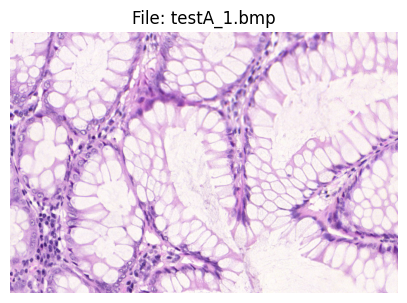

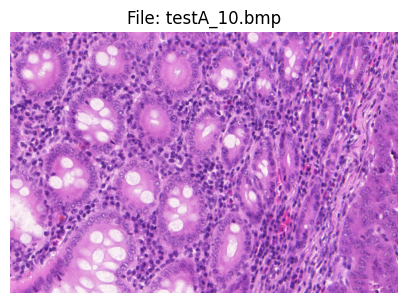

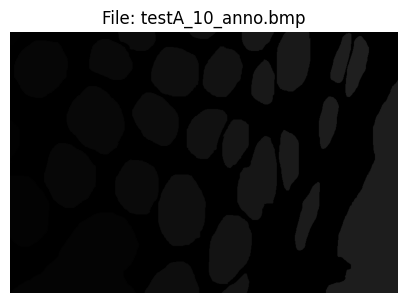

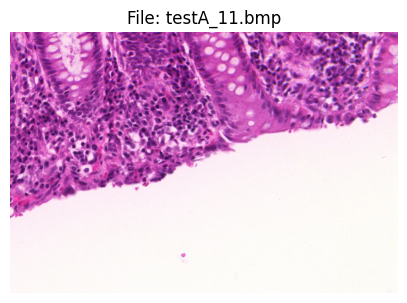

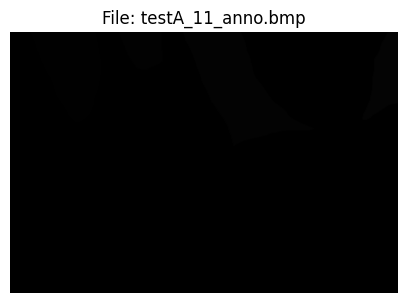

In [6]:
import os
import cv2
import matplotlib.pyplot as plt


files = sorted([f for f in os.listdir(data_dir) if f.endswith('.bmp')])

for i, file in enumerate(files[:5]): 
    img = cv2.imread(os.path.join(data_dir, file), cv2.IMREAD_COLOR)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  

    plt.figure(figsize=(5, 5))
    plt.imshow(img_rgb)
    plt.title(f'File: {file}')
    plt.axis('off')
    plt.show()


In [7]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

data_gen_args = dict(rotation_range=20,
                     width_shift_range=0.1,
                     height_shift_range=0.1,
                     shear_range=0.1,
                     zoom_range=0.1,
                     horizontal_flip=True,
                     fill_mode='nearest')

image_datagen = ImageDataGenerator(**data_gen_args)
mask_datagen = ImageDataGenerator(**data_gen_args)

image_datagen.fit(X_train, augment=True)
mask_datagen.fit(Y_train, augment=True)


In [8]:
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

In [9]:
def unet_model(input_size=(256, 256, 3)):
    inputs = Input(input_size)

    c1 = Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    c1 = Dropout(0.1)(c1)
    c1 = Conv2D(64, (3, 3), activation='relu', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)

    c2 = Conv2D(128, (3, 3), activation='relu', padding='same')(p1)
    c2 = Dropout(0.1)(c2)
    c2 = Conv2D(128, (3, 3), activation='relu', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)

    c3 = Conv2D(256, (3, 3), activation='relu', padding='same')(p2)
    c3 = Dropout(0.2)(c3)
    c3 = Conv2D(256, (3, 3), activation='relu', padding='same')(c3)
    p3 = MaxPooling2D((2, 2))(c3)

    c4 = Conv2D(512, (3, 3), activation='relu', padding='same')(p3)
    c4 = Dropout(0.2)(c4)
    c4 = Conv2D(512, (3, 3), activation='relu', padding='same')(c4)
    p4 = MaxPooling2D((2, 2))(c4)

    c5 = Conv2D(1024, (3, 3), activation='relu', padding='same')(p4)
    c5 = Dropout(0.3)(c5)
    c5 = Conv2D(1024, (3, 3), activation='relu', padding='same')(c5)

    u6 = UpSampling2D((2, 2))(c5)
    u6 = concatenate([u6, c4])
    c6 = Conv2D(512, (3, 3), activation='relu', padding='same')(u6)
    c6 = Dropout(0.2)(c6)
    c6 = Conv2D(512, (3, 3), activation='relu', padding='same')(c6)

    u7 = UpSampling2D((2, 2))(c6)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(256, (3, 3), activation='relu', padding='same')(u7)
    c7 = Dropout(0.2)(c7)
    c7 = Conv2D(256, (3, 3), activation='relu', padding='same')(c7)

    u8 = UpSampling2D((2, 2))(c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(128, (3, 3), activation='relu', padding='same')(u8)
    c8 = Dropout(0.1)(c8)
    c8 = Conv2D(128, (3, 3), activation='relu', padding='same')(c8)

    u9 = UpSampling2D((2, 2))(c8)
    u9 = concatenate([u9, c1])
    c9 = Conv2D(64, (3, 3), activation='relu', padding='same')(u9)
    c9 = Dropout(0.1)(c9)
    c9 = Conv2D(64, (3, 3), activation='relu', padding='same')(c9)

    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c9)

    model = Model(inputs=[inputs], outputs=[outputs])
    return model

In [10]:
model = unet_model()


In [11]:


model.compile(optimizer=Adam(learning_rate=1e-4), loss='binary_crossentropy', metrics=['accuracy'])


In [12]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 256, 256,  │      1,792 │ input_layer[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 256, 256,  │          0 │ conv2d[0][0]      │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 256, 256,  │     36,928 │ dropout[0][0]     │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 128, 128,  │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 128, 128,  │     73,856 │ max_pooling2d[0]… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 128, 128,  │          0 │ conv2d_2[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 128, 128,  │    147,584 │ dropout_1[0][0]   │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 64, 64,    │          0 │ conv2d_3[0][0]    │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 64, 64,    │    295,168 │ max_pooling2d_1[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 64, 64,    │          0 │ conv2d_4[0][0]    │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 64, 64,    │    590,080 │ dropout_2[0][0]   │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 32, 32,    │          0 │ conv2d_5[0][0]    │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 32, 32,    │  1,180,160 │ max_pooling2d_2[… │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 32, 32,    │          0 │ conv2d_6[0][0]    │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 32, 32,    │  2,359,808 │ dropout_3[0][0]   │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_3     │ (None, 16, 16,    │          0 │ conv2d_7[0][0]  

 Total params: 31,378,945 (119.70 MB)

 Trainable params: 31,378,945 (119.70 MB)

 Non-trainable params: 0 (0.00 B)

In [14]:
history = model.fit(image_datagen.flow(X_train, Y_train, batch_size=64),
                    validation_data=(X_val, Y_val),
                    epochs=50, 
                    steps_per_epoch=len(X_train) // 16)


Epoch 1/10


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['keras_tensor']. Received: the structure of inputs=*
  warnings.warn(


8/8 ━━━━━━━━━━━━━━━━━━━━ 193s 24s/step - accuracy: 0.3014 - loss: 0.6236 - val_accuracy: 0.4807 - val_loss: 0.0943
Epoch 2/10
1/8 ━━━━━━━━━━━━━━━━━━━━ 2:50 24s/step - accuracy: 0.4264 - loss: 0.2028

2024-10-15 19:20:36.798101: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(value)


8/8 ━━━━━━━━━━━━━━━━━━━━ 39s 2s/step - accuracy: 0.4264 - loss: 0.2028 - val_accuracy: 0.4807 - val_loss: 0.0895
Epoch 3/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 207s 26s/step - accuracy: 0.4896 - loss: 0.1058 - val_accuracy: 0.4807 - val_loss: 0.1768
Epoch 4/10
1/8 ━━━━━━━━━━━━━━━━━━━━ 3:00 26s/step - accuracy: 0.4859 - loss: 0.0759

2024-10-15 19:24:43.933882: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


8/8 ━━━━━━━━━━━━━━━━━━━━ 41s 2s/step - accuracy: 0.4859 - loss: 0.0759 - val_accuracy: 0.4807 - val_loss: 0.1341
Epoch 5/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 209s 26s/step - accuracy: 0.4888 - loss: 0.0832 - val_accuracy: 0.4807 - val_loss: 0.1511
Epoch 6/10
1/8 ━━━━━━━━━━━━━━━━━━━━ 3:00 26s/step - accuracy: 0.4945 - loss: 0.0658

2024-10-15 19:28:53.368823: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


8/8 ━━━━━━━━━━━━━━━━━━━━ 42s 2s/step - accuracy: 0.4945 - loss: 0.0658 - val_accuracy: 0.4807 - val_loss: 0.1520
Epoch 7/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 214s 27s/step - accuracy: 0.4891 - loss: 0.0675 - val_accuracy: 0.4807 - val_loss: 0.1337
Epoch 8/10
1/8 ━━━━━━━━━━━━━━━━━━━━ 3:15 28s/step - accuracy: 0.4698 - loss: 0.0937

2024-10-15 19:33:11.450367: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


8/8 ━━━━━━━━━━━━━━━━━━━━ 44s 2s/step - accuracy: 0.4698 - loss: 0.0937 - val_accuracy: 0.4807 - val_loss: 0.1427
Epoch 9/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 218s 27s/step - accuracy: 0.4938 - loss: 0.0616 - val_accuracy: 0.4807 - val_loss: 0.1085
Epoch 10/10
1/8 ━━━━━━━━━━━━━━━━━━━━ 3:19 29s/step - accuracy: 0.5166 - loss: 0.0472

2024-10-15 19:37:34.535723: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


8/8 ━━━━━━━━━━━━━━━━━━━━ 45s 2s/step - accuracy: 0.5166 - loss: 0.0472 - val_accuracy: 0.4807 - val_loss: 0.1118


In [20]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras import backend as K

In [21]:
def g_signal(input, out_size, batch_norm=False):
    x = layers.Conv2D(out_size, (1, 1), padding='same')(input)
    if batch_norm:
        x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    return x

def c_block(x, filter_size, size, dropout, batch_norm=False):

    conv = layers.Conv2D(size, (filter_size, filter_size), padding="same")(x)
    if batch_norm is True:
        conv = layers.BatchNormalization(axis=3)(conv)
    conv = layers.Activation("relu")(conv)

    conv = layers.Conv2D(size, (filter_size, filter_size), padding="same")(conv)
    if batch_norm is True:
        conv = layers.BatchNormalization(axis=3)(conv)
    conv = layers.Activation("relu")(conv)

    if dropout > 0:
        conv = layers.Dropout(dropout)(conv)

    return conv


In [22]:
def attention_gate(x, gating, inter_shape):
    shape_x = K.int_shape(x)
    shape_g = K.int_shape(gating)

    theta_x = layers.Conv2D(inter_shape, (2, 2), strides=(2, 2), padding='same')(x)
    shape_theta_x = K.int_shape(theta_x)

    phi_g = layers.Conv2D(inter_shape, (1, 1), padding='same')(gating)
    upsample_g = layers.Conv2DTranspose(inter_shape, (3, 3),
                                        strides=(shape_theta_x[1] // shape_g[1], shape_theta_x[2] // shape_g[2]),
                                        padding='same')(phi_g)

    concat_xg = layers.add([upsample_g, theta_x])
    act_xg = layers.Activation('relu')(concat_xg)
    psi = layers.Conv2D(1, (1, 1), padding='same')(act_xg)
    sigmoid_xg = layers.Activation('sigmoid')(psi)
    shape_sigmoid = K.int_shape(sigmoid_xg)
    upsample_psi = layers.UpSampling2D(size=(shape_x[1] // shape_sigmoid[1], shape_x[2] // shape_sigmoid[2]))(sigmoid_xg)

    upsample_psi = dup_axis(upsample_psi, shape_x[3])

    y = layers.multiply([upsample_psi, x])

    result = layers.Conv2D(shape_x[3], (1, 1), padding='same')(y)
    result_bn = layers.BatchNormalization()(result)
    return result_bn

In [26]:
def dup_axis(tensor, rep):
    return layers.Lambda(lambda x, repnum: K.repeat_elements(x, repnum, axis=3),
                         arguments={'repnum': rep})(tensor)

def Attention_UWNet_v2(input_shape=(256, 256, 3), NUM_CLASSES=1, dropout_rate=0.0, batch_norm=True):
   
    FILTER_NUM = 64  
    FILTER_SIZE = 3
    UP_SAMP_SIZE = 2

    inputs = layers.Input((256, 256, 3), dtype=tf.float32)
    conv_128 = c_block(inputs, FILTER_SIZE, FILTER_NUM, dropout_rate, batch_norm)
    pool_64 = layers.MaxPooling2D(pool_size=(2, 2))(conv_128)

    conv_64 = c_block(pool_64, FILTER_SIZE, 2*FILTER_NUM, dropout_rate, batch_norm)
    pool_32 = layers.MaxPooling2D(pool_size=(2, 2))(conv_64)

    conv_32 = c_block(pool_32, FILTER_SIZE, 4*FILTER_NUM, dropout_rate, batch_norm)
    pool_16 = layers.MaxPooling2D(pool_size=(2, 2))(conv_32)

    conv_16 = c_block(pool_16, FILTER_SIZE, 8*FILTER_NUM, dropout_rate, batch_norm)
    pool_8 = layers.MaxPooling2D(pool_size=(2, 2))(conv_16)

    conv_8 = c_block(pool_8, FILTER_SIZE, 16*FILTER_NUM, dropout_rate, batch_norm)

    gating_16 = g_signal(conv_8, 8*FILTER_NUM, batch_norm)
    att_16 = attention_gate(conv_16, gating_16, 8*FILTER_NUM)
    up_16 = layers.UpSampling2D(size=(UP_SAMP_SIZE, UP_SAMP_SIZE))(conv_8)
    up_16 = layers.concatenate([up_16, att_16], axis=3)
    up_conv_16 = c_block(up_16, FILTER_SIZE, 8*FILTER_NUM, dropout_rate, batch_norm)

    gating_32 = g_signal(up_conv_16, 4*FILTER_NUM, batch_norm)
    att_32 = attention_gate(conv_32, gating_32, 4*FILTER_NUM)
    up_32 = layers.UpSampling2D(size=(UP_SAMP_SIZE, UP_SAMP_SIZE))(up_conv_16)
    up_32 = layers.concatenate([up_32, att_32], axis=3)
    up_conv_32 = c_block(up_32, FILTER_SIZE, 4*FILTER_NUM, dropout_rate, batch_norm)

    gating_64 = g_signal(up_conv_32, 2*FILTER_NUM, batch_norm)
    att_64 = attention_gate(conv_64, gating_64, 2*FILTER_NUM)
    up_64 = layers.UpSampling2D(size=(UP_SAMP_SIZE, UP_SAMP_SIZE))(up_conv_32)
    up_64 = layers.concatenate([up_64, att_64], axis=3)
    up_conv_64 = c_block(up_64, FILTER_SIZE, 2*FILTER_NUM, dropout_rate, batch_norm)

    gating_128 = g_signal(up_conv_64, FILTER_NUM, batch_norm)
    att_128 = attention_gate(conv_128, gating_128, FILTER_NUM)
    up_128 = layers.UpSampling2D(size=(UP_SAMP_SIZE, UP_SAMP_SIZE))(up_conv_64)
    up_128 = layers.concatenate([up_128, att_128], axis=3)
    up_conv_128 = c_block(up_128, FILTER_SIZE, FILTER_NUM, dropout_rate, batch_norm)

    conv_final = layers.Conv2D(NUM_CLASSES, (1, 1), activation='sigmoid')(up_conv_128)

    model = models.Model(inputs, conv_final, name="Attention_UWNet_v2")
    return model

In [27]:
from tensorflow.keras.optimizers import Adam

input_shape = (128, 128, 3)  
NUM_CLASSES = 1  
model = Attention_UWNet_v2(input_shape, NUM_CLASSES, dropout_rate=0.1, batch_norm=True)

model.compile(optimizer=Adam(learning_rate=1e-4), 
              loss='binary_crossentropy', 
              metrics=['accuracy'])

model.summary()

Model: "Attention_UWNet_v2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_5       │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_115 (Conv2D) │ (None, 256, 256,  │      1,792 │ input_layer_5[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256, 256,  │        256 │ conv2d_115[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_30       │ (None, 256, 256,  │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_116 (Conv2D) │ (None, 256, 256,  │     36,928 │ activation_30[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256, 256,  │        256 │ conv2d_116[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_31       │ (None, 256, 256,  │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_45          │ (None, 256, 256,  │          0 │ activation_31[0]… │
│ (Dropout)           │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_20    │ (None, 128, 128,  │          0 │ dropout_45[0][0]  │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_117 (Conv2D) │ (None, 128, 128,  │     73,856 │ max_pooling2d_20… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        512 │ conv2d_117[0][0]  │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_32       │ (None, 128, 128,  │          0 │ batch_normalizat… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_118 (Conv2D) │ (None, 128, 128,  │    147,584 │ activation_32[0]… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        512 │ conv2d_118[0][0]  │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_33       │ (None, 128, 128,  │          0 │ batch_normalizat… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_46          │ (None, 128, 128,  │          0 │ activation_33[0]… │
│ (Dropout)           │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_21    │ (None, 64, 64,    │          0 │ dropout_46[0][0]

 Total params: 37,334,661 (142.42 MB)

 Trainable params: 37,319,045 (142.36 MB)

 Non-trainable params: 15,616 (61.00 KB)

In [28]:

history = model.fit(image_datagen.flow(X_train, Y_train, batch_size=16),
                    validation_data=(X_val, Y_val),
                    epochs=1, 
                    steps_per_epoch=len(X_train) // 16)

8/8 ━━━━━━━━━━━━━━━━━━━━ 310s 38s/step - accuracy: 0.4371 - loss: 0.4055 - val_accuracy: 0.4807 - val_loss: 0.6744
